# Realistic face generator

## Introduction

In this project, we will define and train a DCGAN on a dataset of faces: Our goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks, from loading in data to defining and training generative adversarial networks.

At the end of the notebook, we will be able to visualize the results of our trained generator to see how it performs: Our generated samples should look like fairly realistic faces with small amounts of noise.

As a technical prerequisite, to perform that, first, we need to make some imports:

In [1]:
# Needed imports:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import realistic_face_unittests as tests
import os, time, torch
from torch import nn
from torchvision import datasets, transforms
from torch.nn import Conv2d, BatchNorm2d, ConvTranspose2d, Linear, BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn.functional import leaky_relu, relu, tanh
from workspace_utils import active_session

## Get the data

Here, we will be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train our GANs.

This dataset is more complex than other classical datasets (like MNIST or SVHN), and so, we should prepare to define deeper networks and train them for a longer time to get good results!

*Nota Bene:* We will going to use GPU for training.

## Pre-process the data

### Initial step

Since the project's main focus is on building the GANs, *some* of the pre-processing has been done and will not be exposed in this notebook: Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images.

This pre-processed dataset is a smaller subset of the very large CelebA data.

Some sample data is shown below:

<img src='assets/processed_face_data.png' />

*Nota Bene:* This data can be downloaded [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip): This is a zip file which need to be extracted in the home directory of this notebook for further loading and processing. After extracting the data, a directory of data `processed_celeba_small/` should be present in the home directory.

In [2]:
# Comment out after execution:
!unzip processed_celeba_small.zip

In [3]:
# Define dataset workspace:
data_dir = 'processed_celeba_small/'

### Clean and load in the data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations: Since we are going to generate faces, we won't need the annotations, we will only need the images.

*Nota Bene:* Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

In the initial step, some pre-processings have been performed, but we still need to transform the pre-processed data.

For that, we are going to create a DataLoader.

The following `get_dataloader` function should satisfy these two requirements:
* Images should be square, Tensor images of size `image_size x image_size` in the x and y dimensions.
* The function should return a DataLoader that shuffles and batches these Tensor images.

*Nota Bene:* To create a dataset given a directory of images, we are going to use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [4]:
# Function to create a data loader:

def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/', num_workers=0):
    """
    Batch the neural network data using DataLoader
    Parameters
     batch_size - the size of each batch (the number of images in a batch)
     image_size - the square size of the image data (x, y)
     data_dir - the directory where image data is located
     num_workers - number of subprocesses to use for data loading
    Returns
     data_loader - DataLoader with batched data
    """
    
    # Resize and normalize the images:
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    
    # Define data set using ImageFolder:
    data_set = datasets.ImageFolder(data_dir, transform)
    
    # Create data loader using DataLoader:
    data_loader = DataLoader(dataset=data_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    
    # Return data loader:
    return data_loader

Now, thanks to the above function, we can create a dataloader, `celeba_train_loader`, and view images.

For that, first, we need to choose appropriate hyperparameters:
* We have to decide on any reasonable `batch_size` parameter.
* Our `image_size` must be `32`: Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters:
batch_size = 64
image_size = 32

# Call function and get a dataloader:
celeba_train_loader = get_dataloader(batch_size, image_size)

### Visualize the data

Next, we can view some images! We should see square images of somewhat-centered faces.

*Nota Bene:* We will need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image. For that, we are going to use the function `imshow` defined below.

In [6]:
# Simple function to visualize data:

def imshow(img):
    
    # Transform image to NumPy array:
    npimg = img.numpy()
    
    # Adapt color channels to Matplotlib convention:
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

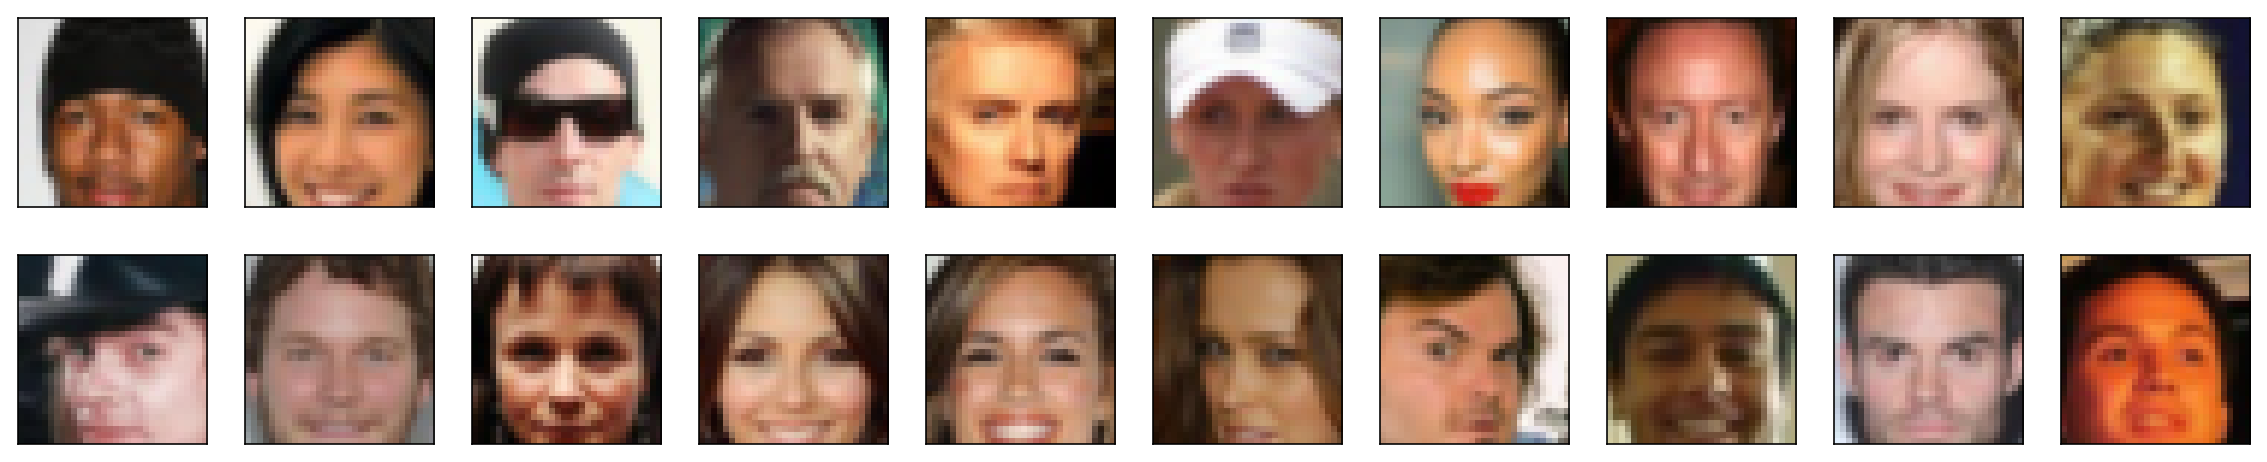

In [7]:
# Obtain one batch of training images:
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next()

# Plot the images in the batch, along with the corresponding labels:
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

### Last step

To finish to pre-process the data, we need to perform a last step: We know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1.

*Nota Bene:* Right now, they are in a range from 0-1.

In [8]:
# Simple scale function:

def scale(x, feature_range=(-1, 1)):
    """
    'scale' takes in an image x and returns that image, scaled
    with a feature_range of pixel values from -1 to 1.
    This function assumes that the input x is already scaled from 0-1.
    """
    
    # Scale from 0-1 to feature_range:
    min, max = feature_range
    x = x * (max - min) + min
    
    # Return scaled x:
    return x

In [9]:
# Check scaled range:
img = images[0]
scaled_img = scale(img)

# Results should be close to -1 to 1:
print("Scaled range:")
print("- Min: ", scaled_img.min())
print("- Max: ", scaled_img.max())

Scaled range:
- Min:  tensor(-0.9529)
- Max:  tensor(0.8667)


## Define the model

A GAN is comprised of two adversarial networks: a discriminator and a generator. So, we are going to build them!

### Discriminator

Our first task will be to define the discriminator. This is a "classical" convolutional classifier, only without any maxpooling layers. To deal with this complex data, we are going to use a deep network with normalization.

The first thing we are going to do is to create the discriminator class, taking into account the following elements:
* The inputs to the discriminator are 32x32x3 tensor images.
* The output should be a single value that will indicate whether a given image is real or fake.

#### *Convolutional helper function*

Before to define the discriminator class, we are going to provide a `conv` function, which creates a convolutional layer and an optional batch normalization layer.

In [10]:
# Helper conv function:

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Creates a convolutional layer, with optional batch normalization.
    """
    
    # Initialize layers:
    layers = []
    
    # Define convolutional layer:
    conv_layer = Conv2d(in_channels=in_channels, out_channels=out_channels,
                        kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    # Add convolutional layer to layers:
    layers.append(conv_layer)

    # Add batch normalization layer:
    if batch_norm:
        layers.append(BatchNorm2d(out_channels))
    
    # Return layers:
    return nn.Sequential(*layers)

#### *Discriminator class*

We can now define the discriminator class.

In [11]:
# Discriminator class:

class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        Parameters
         conv_dim - the depth of the first convolutional layer
        """
        
        super(Discriminator, self).__init__()

        # Convolutional layers:
        self.conv_1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv_2 = conv(conv_dim, conv_dim*2, 4)
        self.conv_3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv_4 = conv(conv_dim*4, conv_dim*8, 4)
        
        # Classification layer:
        self.conv_5 = conv(conv_dim*8, 1, kernel_size=4, stride=1, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        Parameters
         x - the input to the neural network  
        Returns
         out - discriminator logits (the output of the neural network)
        """
        
        # Leaky ReLU applied to all convolutional layers but last:
        out = leaky_relu(self.conv_1(x), 0.2)
        out = leaky_relu(self.conv_2(out), 0.2)
        out = leaky_relu(self.conv_3(out), 0.2)
        out = leaky_relu(self.conv_4(out), 0.2)
        
        # Last, classification layer:
        out = self.conv_5(out)
        out = out.view(-1, 1)
        
        # Return output of the neural network:
        return out

# Perform some unit tests on the class:

print("Class 'Discriminator' has been defined: Running some unit tests...")
tests.test_discriminator(Discriminator)

Class 'Discriminator' has been defined: Running some unit tests...
Test passed!


### Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

As it has been done with the discriminator, the first thing we are going to do is to create the generator class, taking into account the following elements:
* The inputs to the generator are vectors of some length `z_size`.
* The output should be an image of shape `32x32x3`.

#### *Transpose convolutional helper function*

Before to define the generator class, we are going to provide a `deconv` function, which creates a transpose convolutional layer and an optional batch normalization layer.

In [12]:
# Helper deconv function:

def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True, output_padding=0):
    """
    Creates a transposed-convolutional layer, with optional batch normalization.
    """
    
    # Initialize layers:
    layers = []
    
    # Define transpose convolutional layer:
    transpose_conv_layer = ConvTranspose2d(in_channels, out_channels, kernel_size,
                                           stride, padding, output_padding, bias=False)
    
    # Add transpose convolutional layer to layers:
    layers.append(transpose_conv_layer)
    
    # Add batch normalization layer:
    if batch_norm:
        layers.append(BatchNorm2d(out_channels))
    
    # Return layers:
    return nn.Sequential(*layers)

#### *Generator class*

We can now define the generator class.

In [13]:
# Generator class:

class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        Parameters
         z_size - the length of the input latent vector, z
         conv_dim - the depth of the inputs to the last transpose convolutional layer
        """
        
        super(Generator, self).__init__()

        # Link the depth of the inputs to the last transpose convolutional layer:
        self.conv_dim = conv_dim
        
        # Fully-connected layer:
        self.fc = Linear(z_size, conv_dim*16*2*2)
        
        # Transpose convolutional layers:
        self.t_conv_1 = deconv(conv_dim*16, conv_dim*8, 5, stride=2, padding=2, output_padding=1)
        self.t_conv_2 = deconv(conv_dim*8, conv_dim*4, 5, stride=2, padding=2, output_padding=1)
        self.t_conv_3 = deconv(conv_dim*4, conv_dim*2, 5, stride=2, padding=2, output_padding=1)
        self.t_conv_4 = deconv(conv_dim*2, 3, 5, stride=2, padding=2, output_padding=1, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        Parameters
         x - the input to the neural network
        Returns
         out - a 32x32x3 Tensor image as output
        """
        
        # Fully-connected layer: 
        out = self.fc(x)
        
        # Reshape:
        out = out.view(-1, self.conv_dim*16, 2, 2)
        
        # Transpose convolutional layers with ReLU activation function:
        out = relu(self.t_conv_1(out))
        out = relu(self.t_conv_2(out))
        out = relu(self.t_conv_3(out))

        # Last layer with Tanh activation function:
        out = self.t_conv_4(out)
        out = tanh(out)
        
        # Return a 32x32x3 Tensor image as output:
        return out

# Perform some unit tests on the class:

print("Class 'Generator' has been defined: Running some unit tests...")
tests.test_generator(Generator)

Class 'Generator' has been defined: Running some unit tests...
Test passed!


### Initialize the weights of our networks

To help our models converge, we should initialize the weights of the convolutional and linear layers in our model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), we can noticed that the authors realized it following the following precept:

> *"All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02."*

So, our next task will be to define a weight initialization function that does just this!

Our weight initialization function must take into account the following elements:
* It should initialize only convolutional and linear layers.
* It should initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
# Weights initialization function:

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model.
    The weights are taken from a normal distribution: 
    with mean = 0, std dev = 0.02
    Parameters
     m - a module or layer in a network    
    """
    
    # Classname will be something like "Conv", "BatchNorm2d", "Linear", etc:
    classname = m.__class__.__name__
    
    # Apply initial weights to convolutional and linear layers:
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        y = 0.02
        m.weight.data.normal_(0., y)
        
        # Set bias term to 0.:
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.fill_(0.)

### Build complete network

Now, we can define our models hyperparameters and instantiate the discriminator and generator from the classes defined above.

In [15]:
# Build our network:

def build_network(d_conv_dim, g_conv_dim, z_size):
    
    # Define discriminator and generator:
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # Initialize model weights:
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)
    
    # Print our network:
    print("*** Discriminator neural network:")
    print()
    print(D)
    print()
    print("*** Generator neural network:")
    print()
    print(G)
    
    # Return Discriminator and generator neural networks:
    return D, G

In [16]:
# Define model hyperparameters:
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

# Build discriminator and generator neural networks:
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

*** Discriminator neural network:

Discriminator(
  (conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

*** Generator neural network:

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=

### Check access to GPU

Here, we are going to check if we have access to GPU: For that, we will set a boolean variable, `train_on_gpu`.

*Nota Bene:* Later, we will be responsible for making sure that models, models inputs, and loss function arguments will be moved to GPU, where appropriate.

In [17]:
# Check for a GPU:

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print("GPU found!")
else:
    print("No GPU found...")

GPU found!


### Discriminator and generator losses

Now, we need to calculate the losses for both types of adversarial networks.

#### *Discriminator losses*

For the discriminator, the total loss is the sum of the losses for real and fake images: `d_loss = d_real_loss + d_fake_loss`.

*Nota Bene:* We have to remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

#### *Generator loss*

The generator loss will look similar only with flipped labels: Indeed, the generator's goal is to get the discriminator to *think* its generated images are *real*.

#### *Define real and fake loss functions*

To define real and fake loss functions, we can choose to use either binary cross entropy or a least squares error: Here, we are going to use binary cross entropy.

In [18]:
# Real loss function:

def real_loss(D_out, smooth=False):
    """
    Calculates how close discriminator outputs are to being real.
    Parameters
     D_out - discriminator logits
    Returns
     loss - real loss
    """
    
    batch_size = D_out.size(0)
    
    # Label smoothing:
    if smooth:
        # Smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        # Real labels = 1.
        labels = torch.ones(batch_size)
        
    # Move labels to GPU if available:     
    if train_on_gpu:
        labels = labels.cuda()
        
    # Binary cross entropy with logits loss:
    criterion = BCEWithLogitsLoss()
    
    # Calculate loss:
    loss = criterion(D_out.squeeze(), labels)
    
    # Return loss:
    return loss


# Fake loss function:

def fake_loss(D_out):
    """
    Calculates how close discriminator outputs are to being fake.
    Parameters
     D_out: discriminator logits
    Returns
     loss - fake loss
    """
    
    batch_size = D_out.size(0)
    
    # Fake labels = 0.
    labels = torch.zeros(batch_size)
    
    # Move labels to GPU if available:
    if train_on_gpu:
        labels = labels.cuda()
        
    # Binary cross entropy with logits loss:
    criterion = nn.BCEWithLogitsLoss()
    
    # Calculate loss:
    loss = criterion(D_out.squeeze(), labels)
    
    # Return loss:
    return loss

### Optimizers

Now, we need to define optimizers for our models - discriminator (D) and generator (G) - with appropriate hyperparameters.

In [19]:
# Hyperparameters for optimizers:
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the discriminator D and generator G:
d_optimizer = Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = Adam(G.parameters(), lr, [beta1, beta2])

## Train the model

Training will involve alternating between training the discriminator and the generator, and for that, we will use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses.

The following elements need to be taken into account:
* We should train the discriminator by alternating on real and fake images.
* Then, we should train the generator, which tries to trick the discriminator and should have an opposing loss function.

### Define a train function

First, we are going to define below the `train` function.

In [20]:
# Create folder 'training' to store training elements (comment out after execution):
os.mkdir('training')

In [21]:
# Train function:

def train(D, G, n_epochs, print_every=100):
    """
    Trains adversarial neural networks for some number of epochs.
    Parameters
     D - discriminator neural network
     G - generator neural network
     n_epochs - number of epochs for training
     print_every - when to print and record losses
    Returns
     losses - D and G losses
    """

    # Track the training session:
    print("Training (for {} epoch(s)):\n*****".format(n_epochs))
    start_time = time.time()
    
    # Create a performance tracking file for the training session:
    perf_file = open('training/training_perf.txt', 'w')
    perf_file.write("# Recording, Discriminator loss, Generator loss\n")
    perf_file.close()
    recording = 1
    
    # Keep track of loss and generated "fake" samples:
    samples = []
    losses = []

    # Get some fixed data for sampling, moved to GPU if available:
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    
    # Move models to GPU if available:
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # Epoch training loop:
    for epoch in range(n_epochs):
        
        # Move to training mode:
        D.train()
        G.train()

        # Batch training loop:
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):
            
            # (1) Train the discriminator on real and fake images:
            
            d_optimizer.zero_grad()
            
            # Real images considered, moved to GPU if available:
            batch_size = real_images.size(0)
            real_images = scale(real_images)
            if train_on_gpu:
                real_images = real_images.cuda()
                
            # Generate fake images, moved to GPU if available:
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on real images:
            D_real = D(real_images)
            d_real_loss = real_loss(D_real, smooth=True)
            
            # Compute the discriminator losses on fake images:
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # Add up losses and perform backpropagation:
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # (2) Train the generator with an adversarial loss:
            
            g_optimizer.zero_grad()
            
            # Generate new fake images, moved to GPU if available:
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the generator losses on fake images flipped labels:
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake, smooth=True)
            
            # Perform backpropagation:
            g_loss.backward()
            g_optimizer.step()

            # (3) Print some loss stats:
            
            if batch_i % print_every == 0:
                
                # Append discriminator and generator losses:
                losses.append((d_loss.item(), g_loss.item()))
                
                # Print discriminator and generator losses:
                print("Epoch {}/{}, Step {}:".format(epoch+1, n_epochs, batch_i))
                print("===> Discriminator loss {:2f}".format(d_loss.item()))
                print("===> Generator loss {:2f}".format(g_loss.item()))
                
                # Register discriminator and generator losses:
                perf_file = open('training/training_perf.txt', 'a')
                perf_file.write("{} {:.2f} {:.2f}\n".format(recording,
                                                            d_loss.item(),
                                                            g_loss.item()))
                perf_file.close()
                recording += 1

        # Move to evaluation mode:
        D.eval()
        G.eval()
        
        # Save models:
        torch.save(D, 'training/D.pth')
        torch.save(G, 'training/G.pth')
        
        # Save sample, fake images:
        samples_z = G(fixed_z)
        samples.append(samples_z)

    # Save training generator samples:
    with open('training/training_samples.pickle', 'wb') as f:
        pkl.dump(samples, f)
        
    # Time performance:
    end_time = time.time()
    total_time = int(end_time - start_time)
    hours = total_time//3600
    minutes = (total_time%3600)//60
    seconds = (total_time%3600)%60
    print("*****\nEnd of the training: {:02d}h {:02d}m {:02d}s".format(hours,
                                                                       minutes,
                                                                       seconds))
    
    # Finally, return losses:
    return losses

### Train our model

We can now set the number of training epochs and train our GAN!

In [22]:
# Set number of epochs: 
n_epochs = 40

# Call training function:
with active_session():
    losses = train(D, G, n_epochs=n_epochs)

Training (for 40 epoch(s)):
*****
Epoch 1/40, Step 0:
===> Discriminator loss 1.507652
===> Generator loss 1.208238
Epoch 1/40, Step 100:
===> Discriminator loss 0.653488
===> Generator loss 3.128226
Epoch 1/40, Step 200:
===> Discriminator loss 1.031247
===> Generator loss 2.032427
Epoch 1/40, Step 300:
===> Discriminator loss 0.883136
===> Generator loss 2.109373
Epoch 1/40, Step 400:
===> Discriminator loss 1.034273
===> Generator loss 1.719874
Epoch 1/40, Step 500:
===> Discriminator loss 1.132112
===> Generator loss 1.321646
Epoch 1/40, Step 600:
===> Discriminator loss 0.890134
===> Generator loss 2.051552
Epoch 1/40, Step 700:
===> Discriminator loss 1.109987
===> Generator loss 1.485955
Epoch 1/40, Step 800:
===> Discriminator loss 0.985192
===> Generator loss 2.232132
Epoch 1/40, Step 900:
===> Discriminator loss 1.088177
===> Generator loss 1.664248
Epoch 1/40, Step 1000:
===> Discriminator loss 0.994480
===> Generator loss 1.861617
Epoch 1/40, Step 1100:
===> Discriminator l

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 2/40, Step 0:
===> Discriminator loss 1.718584
===> Generator loss 2.135472
Epoch 2/40, Step 100:
===> Discriminator loss 1.226535
===> Generator loss 1.940036
Epoch 2/40, Step 200:
===> Discriminator loss 1.102347
===> Generator loss 1.640637
Epoch 2/40, Step 300:
===> Discriminator loss 1.162434
===> Generator loss 1.706225
Epoch 2/40, Step 400:
===> Discriminator loss 1.104526
===> Generator loss 1.325939
Epoch 2/40, Step 500:
===> Discriminator loss 1.070805
===> Generator loss 1.943960
Epoch 2/40, Step 600:
===> Discriminator loss 1.162575
===> Generator loss 1.316743
Epoch 2/40, Step 700:
===> Discriminator loss 1.131076
===> Generator loss 1.627962
Epoch 2/40, Step 800:
===> Discriminator loss 0.989437
===> Generator loss 1.670413
Epoch 2/40, Step 900:
===> Discriminator loss 1.042647
===> Generator loss 1.467385
Epoch 2/40, Step 1000:
===> Discriminator loss 1.100765
===> Generator loss 1.164230
Epoch 2/40, Step 1100:
===> Discriminator loss 1.054242
===> Generator loss 1

Epoch 8/40, Step 800:
===> Discriminator loss 1.019144
===> Generator loss 1.051900
Epoch 8/40, Step 900:
===> Discriminator loss 1.155681
===> Generator loss 1.456568
Epoch 8/40, Step 1000:
===> Discriminator loss 1.128345
===> Generator loss 1.338471
Epoch 8/40, Step 1100:
===> Discriminator loss 0.999643
===> Generator loss 1.592645
Epoch 8/40, Step 1200:
===> Discriminator loss 1.006066
===> Generator loss 1.733923
Epoch 8/40, Step 1300:
===> Discriminator loss 1.217234
===> Generator loss 1.186724
Epoch 8/40, Step 1400:
===> Discriminator loss 0.922764
===> Generator loss 1.259499
Epoch 9/40, Step 0:
===> Discriminator loss 1.124367
===> Generator loss 1.660089
Epoch 9/40, Step 100:
===> Discriminator loss 1.217707
===> Generator loss 1.403518
Epoch 9/40, Step 200:
===> Discriminator loss 1.011269
===> Generator loss 1.653413
Epoch 9/40, Step 300:
===> Discriminator loss 1.034506
===> Generator loss 1.633634
Epoch 9/40, Step 400:
===> Discriminator loss 1.182671
===> Generator los

Epoch 15/40, Step 0:
===> Discriminator loss 1.081236
===> Generator loss 1.307598
Epoch 15/40, Step 100:
===> Discriminator loss 0.676406
===> Generator loss 2.900083
Epoch 15/40, Step 200:
===> Discriminator loss 0.719979
===> Generator loss 1.821695
Epoch 15/40, Step 300:
===> Discriminator loss 0.932276
===> Generator loss 1.324696
Epoch 15/40, Step 400:
===> Discriminator loss 0.595420
===> Generator loss 2.699718
Epoch 15/40, Step 500:
===> Discriminator loss 0.748676
===> Generator loss 1.102891
Epoch 15/40, Step 600:
===> Discriminator loss 0.885220
===> Generator loss 2.172848
Epoch 15/40, Step 700:
===> Discriminator loss 0.819669
===> Generator loss 1.639082
Epoch 15/40, Step 800:
===> Discriminator loss 0.747085
===> Generator loss 1.522661
Epoch 15/40, Step 900:
===> Discriminator loss 0.983923
===> Generator loss 2.455615
Epoch 15/40, Step 1000:
===> Discriminator loss 0.742000
===> Generator loss 1.720454
Epoch 15/40, Step 1100:
===> Discriminator loss 1.589146
===> Gene

Epoch 21/40, Step 700:
===> Discriminator loss 0.638431
===> Generator loss 2.304209
Epoch 21/40, Step 800:
===> Discriminator loss 0.672285
===> Generator loss 2.573189
Epoch 21/40, Step 900:
===> Discriminator loss 0.664260
===> Generator loss 2.384750
Epoch 21/40, Step 1000:
===> Discriminator loss 0.650483
===> Generator loss 1.989273
Epoch 21/40, Step 1100:
===> Discriminator loss 0.630558
===> Generator loss 3.104603
Epoch 21/40, Step 1200:
===> Discriminator loss 0.653003
===> Generator loss 1.952448
Epoch 21/40, Step 1300:
===> Discriminator loss 0.567001
===> Generator loss 2.470332
Epoch 21/40, Step 1400:
===> Discriminator loss 0.525217
===> Generator loss 4.156966
Epoch 22/40, Step 0:
===> Discriminator loss 1.133861
===> Generator loss 2.997787
Epoch 22/40, Step 100:
===> Discriminator loss 0.573786
===> Generator loss 3.704704
Epoch 22/40, Step 200:
===> Discriminator loss 0.667206
===> Generator loss 3.113050
Epoch 22/40, Step 300:
===> Discriminator loss 0.493981
===> G

Epoch 27/40, Step 1400:
===> Discriminator loss 0.716944
===> Generator loss 3.959470
Epoch 28/40, Step 0:
===> Discriminator loss 0.602440
===> Generator loss 2.729133
Epoch 28/40, Step 100:
===> Discriminator loss 0.525216
===> Generator loss 2.062161
Epoch 28/40, Step 200:
===> Discriminator loss 0.668343
===> Generator loss 1.689289
Epoch 28/40, Step 300:
===> Discriminator loss 0.431868
===> Generator loss 3.713842
Epoch 28/40, Step 400:
===> Discriminator loss 0.450209
===> Generator loss 4.119654
Epoch 28/40, Step 500:
===> Discriminator loss 0.527359
===> Generator loss 3.452373
Epoch 28/40, Step 600:
===> Discriminator loss 0.497774
===> Generator loss 2.802623
Epoch 28/40, Step 700:
===> Discriminator loss 0.671975
===> Generator loss 2.049637
Epoch 28/40, Step 800:
===> Discriminator loss 0.586860
===> Generator loss 2.084057
Epoch 28/40, Step 900:
===> Discriminator loss 0.463579
===> Generator loss 3.517225
Epoch 28/40, Step 1000:
===> Discriminator loss 0.532925
===> Gene

Epoch 34/40, Step 600:
===> Discriminator loss 0.452539
===> Generator loss 3.017800
Epoch 34/40, Step 700:
===> Discriminator loss 0.486530
===> Generator loss 3.252932
Epoch 34/40, Step 800:
===> Discriminator loss 0.658473
===> Generator loss 1.690881
Epoch 34/40, Step 900:
===> Discriminator loss 0.466296
===> Generator loss 3.709946
Epoch 34/40, Step 1000:
===> Discriminator loss 0.558682
===> Generator loss 2.141665
Epoch 34/40, Step 1100:
===> Discriminator loss 0.533221
===> Generator loss 2.457959
Epoch 34/40, Step 1200:
===> Discriminator loss 0.554738
===> Generator loss 3.007747
Epoch 34/40, Step 1300:
===> Discriminator loss 0.475638
===> Generator loss 3.082884
Epoch 34/40, Step 1400:
===> Discriminator loss 0.433331
===> Generator loss 3.300919
Epoch 35/40, Step 0:
===> Discriminator loss 0.749072
===> Generator loss 2.192835
Epoch 35/40, Step 100:
===> Discriminator loss 0.423487
===> Generator loss 3.706549
Epoch 35/40, Step 200:
===> Discriminator loss 0.973060
===> G

Epoch 40/40, Step 1300:
===> Discriminator loss 0.798833
===> Generator loss 2.799647
Epoch 40/40, Step 1400:
===> Discriminator loss 0.484388
===> Generator loss 3.827441
*****
End of the training: 10h 58m 38s


### Visualize the training loss

To visualize how the training has gone through the epochs, we can plot the training losses for the generator and discriminator, recorded after each epoch.

#### *Performance file*

In [23]:
# Read the data contained in the performance file:

recording_list = []
discriminator_loss_list = []
generator_loss_list = []

with open('training/training_perf.txt', 'r') as perf_file:
    f_line = perf_file.readline()
    while f_line != "":
        if f_line[0] != "#":
            f_line_l = f_line.strip().split()
            recording_list.append(int(f_line_l[0]))
            discriminator_loss_list.append(float(f_line_l[1]))
            generator_loss_list.append(float(f_line_l[2]))
        f_line = perf_file.readline()
        
# Recording and losses extremum:

print("Recording evolves from {} to {}.".format(int(min(recording_list)), int(max(recording_list))))
print("Discriminator loss evolves from {:.2f} to {:.2f}.".format(min(discriminator_loss_list),
                                                                 max(discriminator_loss_list)))
print("Generator loss evolves from {:.2f} to {:.2f}.".format(min(generator_loss_list),
                                                                 max(generator_loss_list)))

Recording evolves from 1 to 600.
Discriminator loss evolves from 0.39 to 2.18.
Generator loss evolves from 0.76 to 5.44.


#### *Graph*

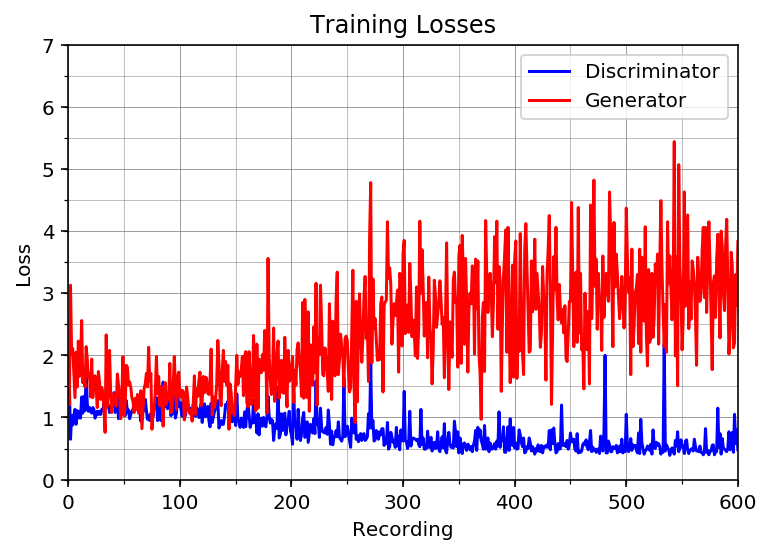

In [24]:
# Define the graph:
fig, ax = plt.subplots()

# Configuration of the graph:
ax.set_title('Training Losses')
ax.plot(recording_list, discriminator_loss_list, color='blue', linestyle='solid',\
        label='Discriminator')
ax.plot(recording_list, generator_loss_list, color='red', linestyle='solid',\
        label='Generator')
ax.legend()
ax.set_xlim(0, 600)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(7))
ax.xaxis.set_minor_locator(mpl.ticker.MaxNLocator(13))
ax.grid(color="grey", which="major", axis='x', linestyle='solid', linewidth=0.25)
ax.grid(color="grey", which="minor", axis='x', linestyle='solid', linewidth=0.25)
ax.set_xlabel('Recording')
ax.set_ylim(0., 7.)
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(8))
ax.yaxis.set_minor_locator(mpl.ticker.MaxNLocator(15))
ax.grid(color="grey", which="major", axis='y', linestyle='solid', linewidth=0.25)
ax.grid(color="grey", which="minor", axis='y', linestyle='solid', linewidth=0.25)
ax.set_ylabel('Loss')

# Save the training graph:
fig.savefig('training/training_graph.png')

## Generate samples from training

Now, it's time to view samples of images from the generator, and check the effect of the training.

In [25]:
# Helper function for viewing a list of passed in sample images:

def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [26]:
# Load samples from generator, taken while training:
with open('training/training_samples.pickle', 'rb') as f:
    samples = pkl.load(f)

### Epoch 1

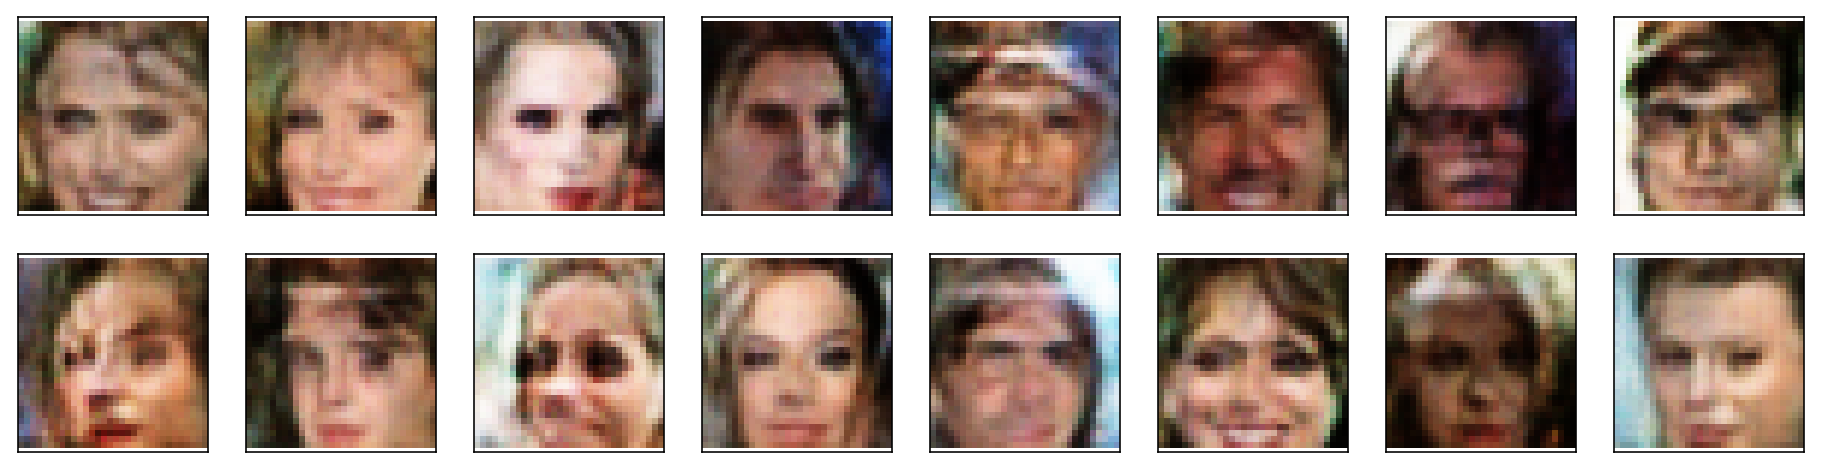

In [27]:
# Visualize the samples for epoch 1:
view_samples(1, samples)

### Epoch 5

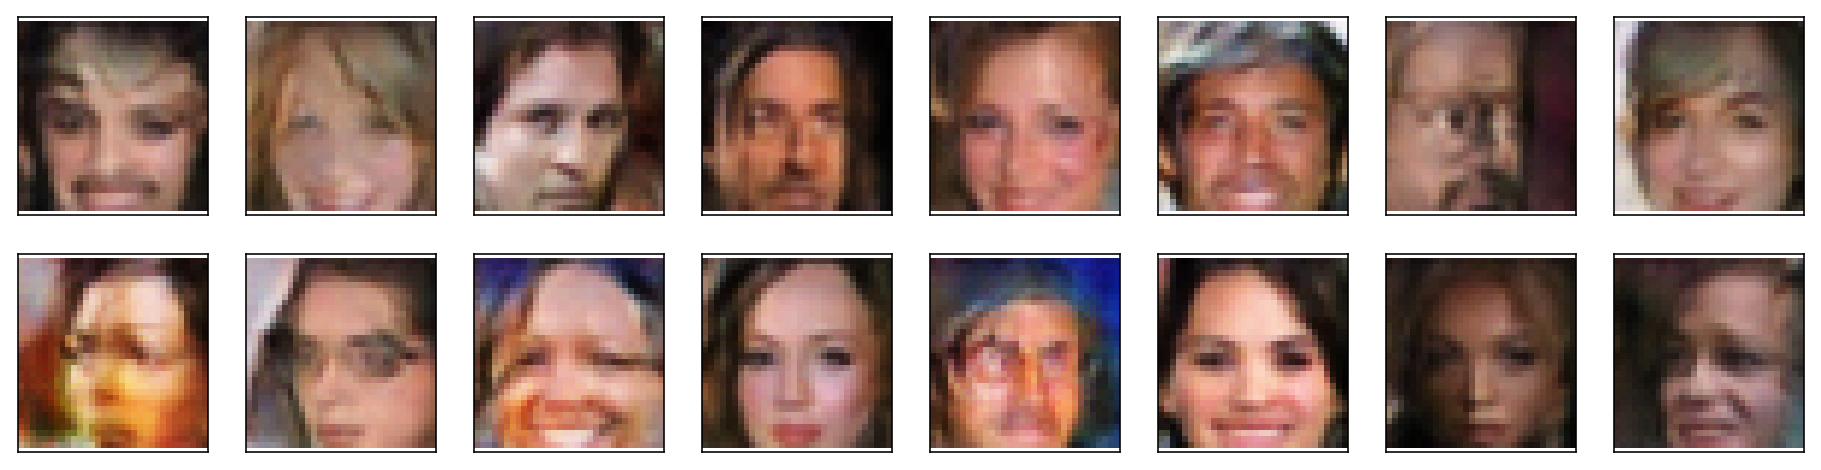

In [28]:
# Visualize the samples for epoch 5:
view_samples(5, samples)

### Epoch 10

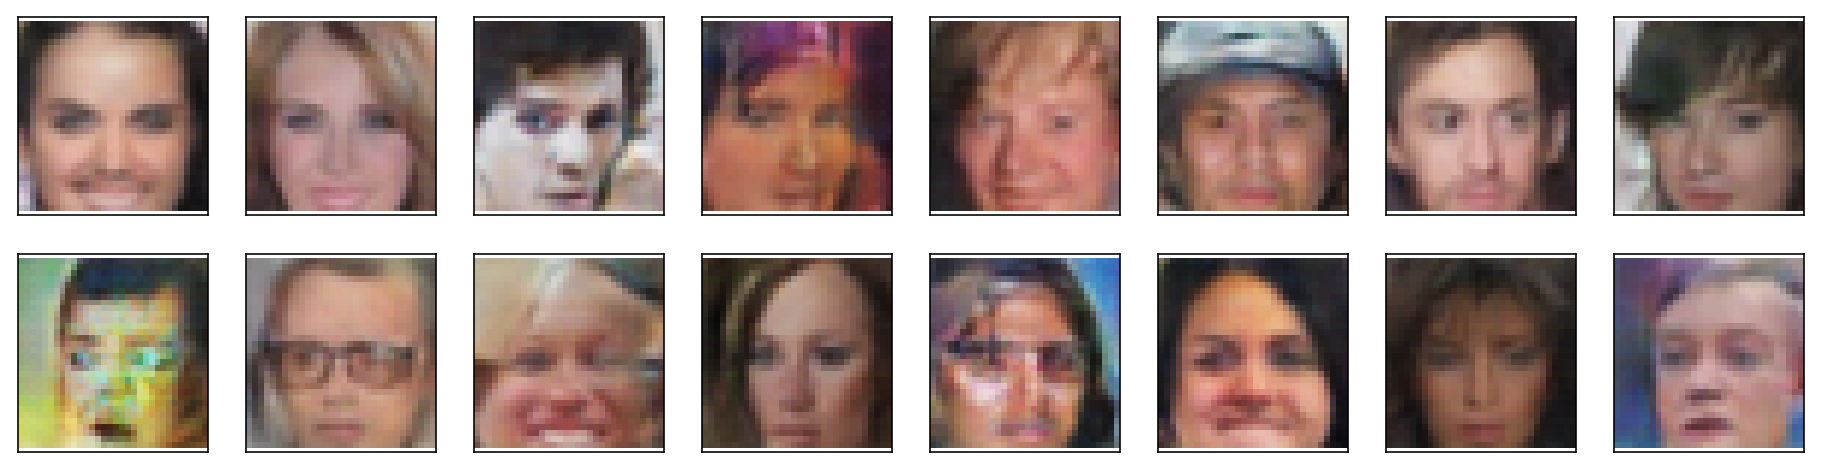

In [29]:
# Visualize the samples for epoch 10:
view_samples(10, samples)

### Epoch 15

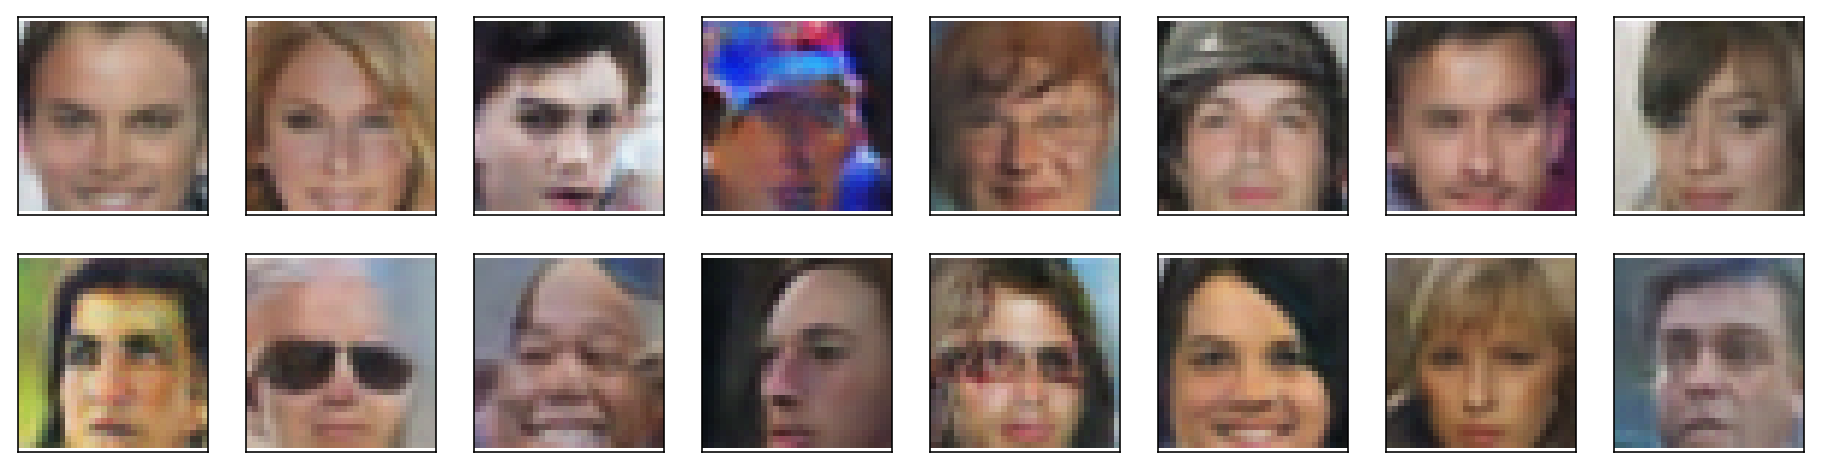

In [30]:
# Visualize the samples for epoch 15:
view_samples(15, samples)

### Epoch 20

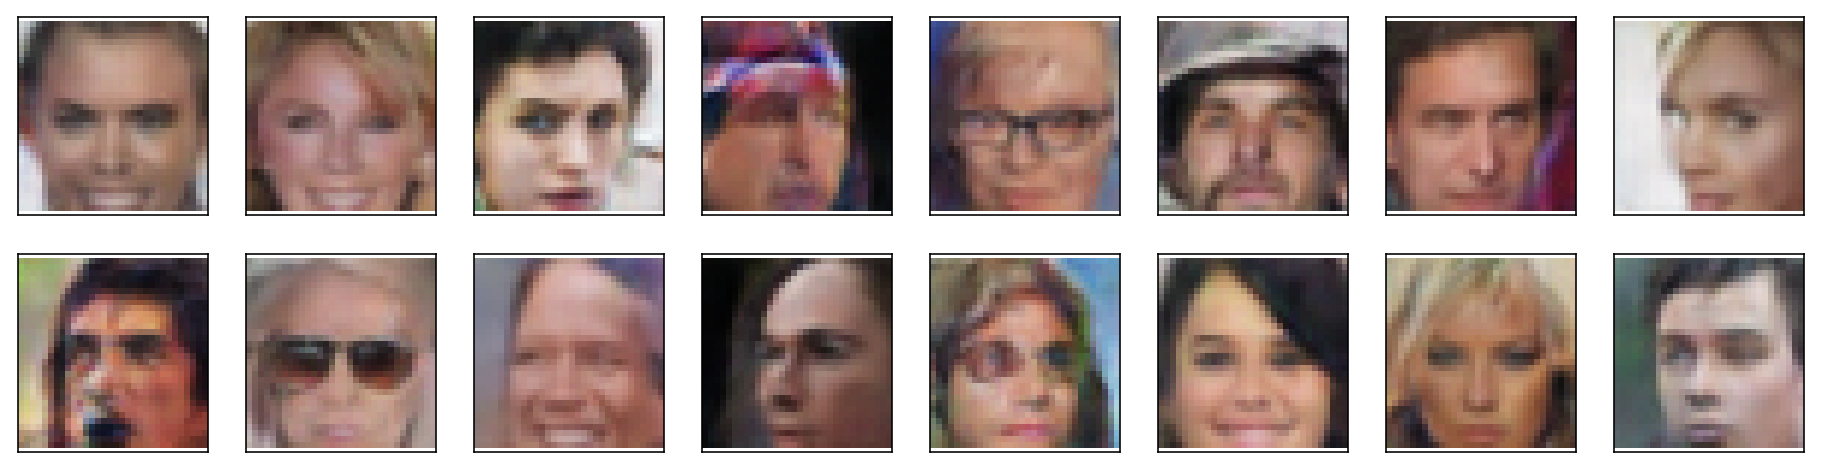

In [31]:
# Visualize the samples for epoch 20:
view_samples(20, samples)

### Epoch 25

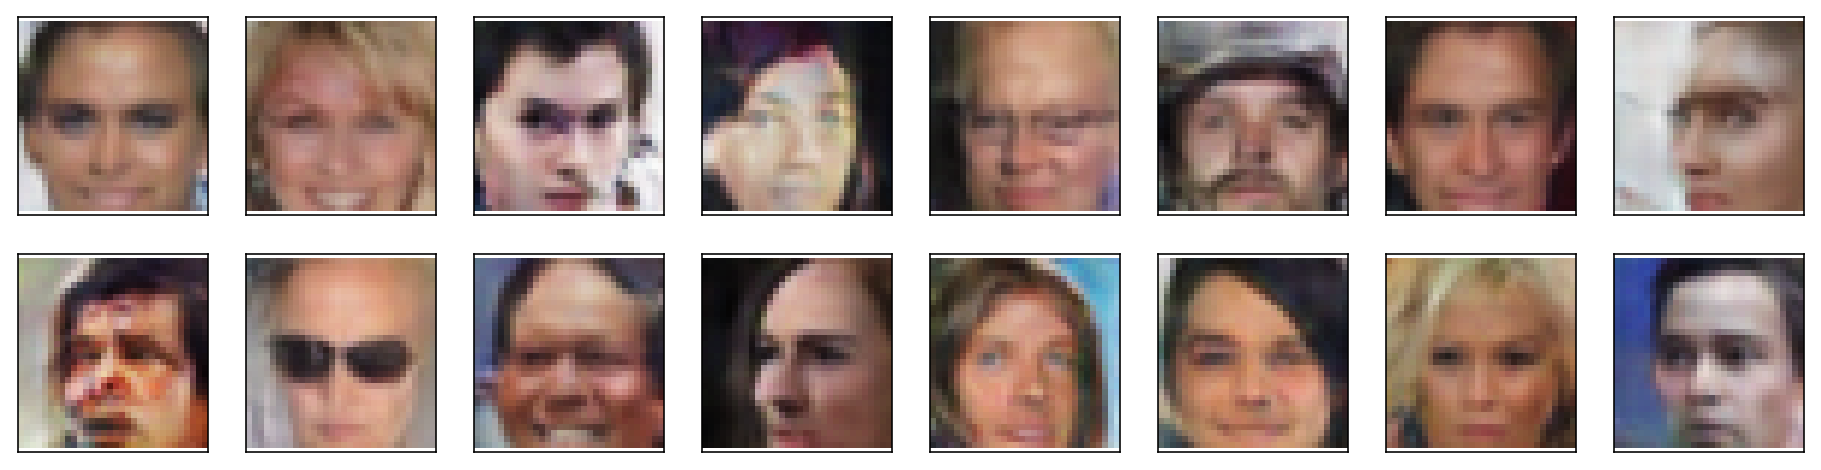

In [32]:
# Visualize the samples for epoch 25:
view_samples(25, samples)

### Epoch 30

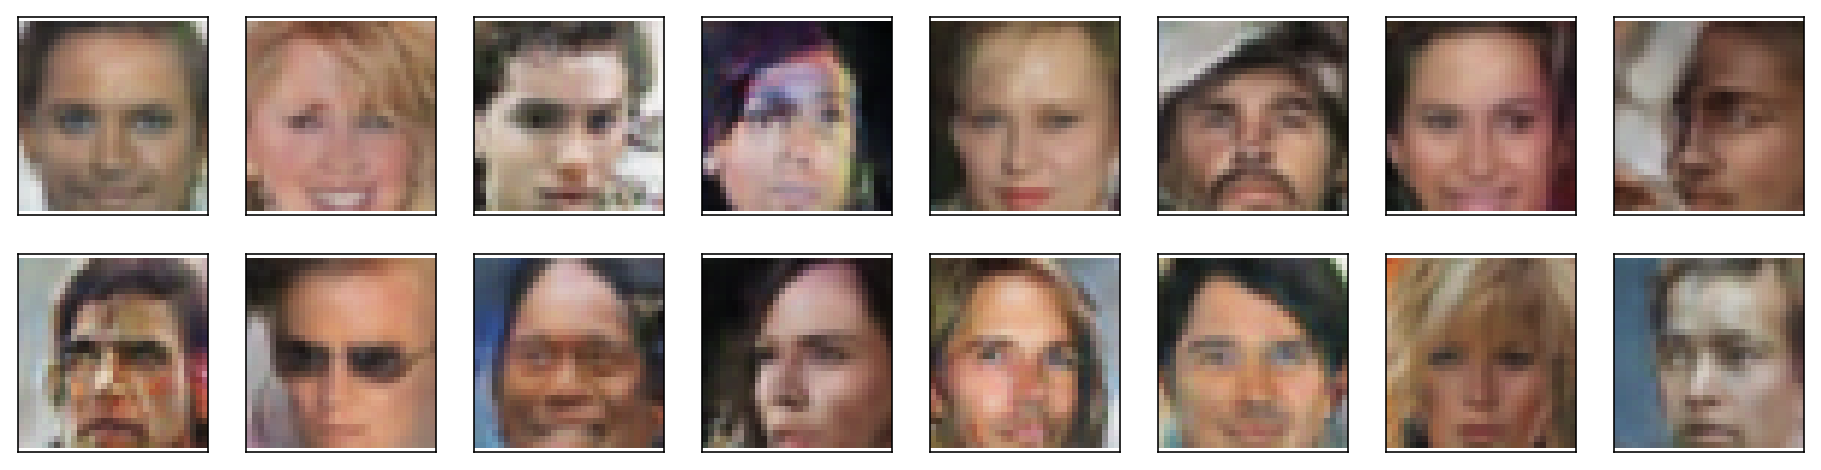

In [33]:
# Visualize the samples for epoch 30:
view_samples(30, samples)

### Epoch 35

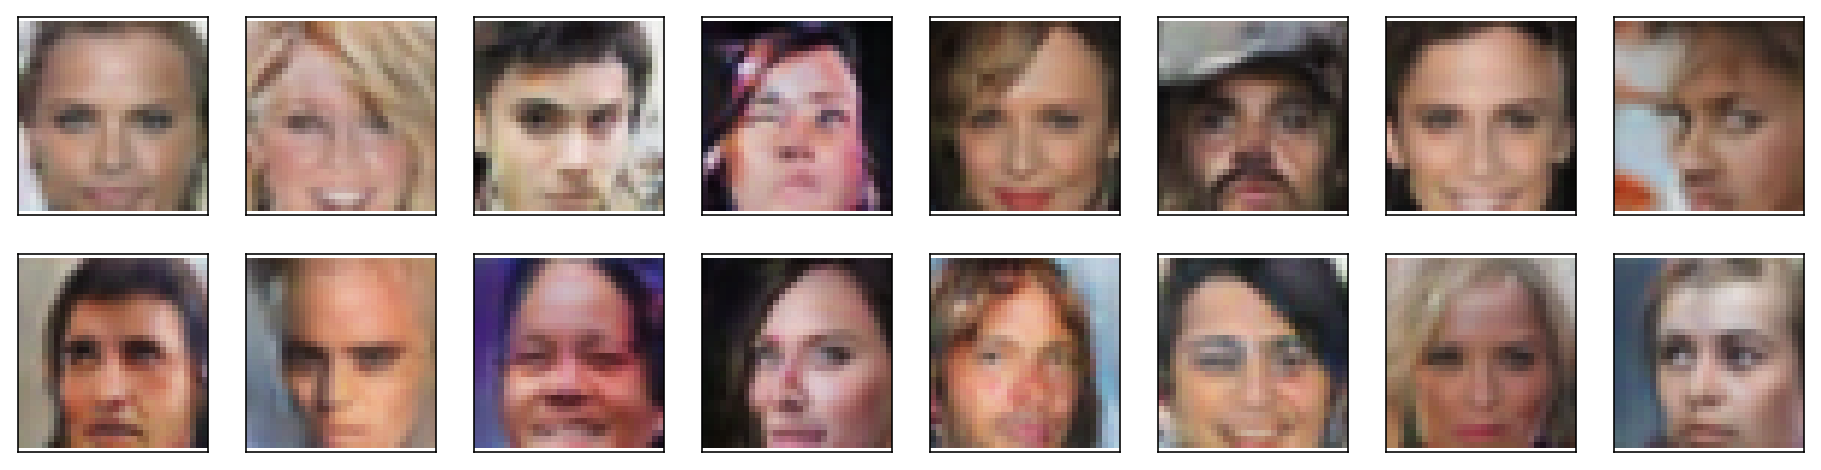

In [34]:
# Visualize the samples for epoch 35:
view_samples(35, samples)

### Epoch 40

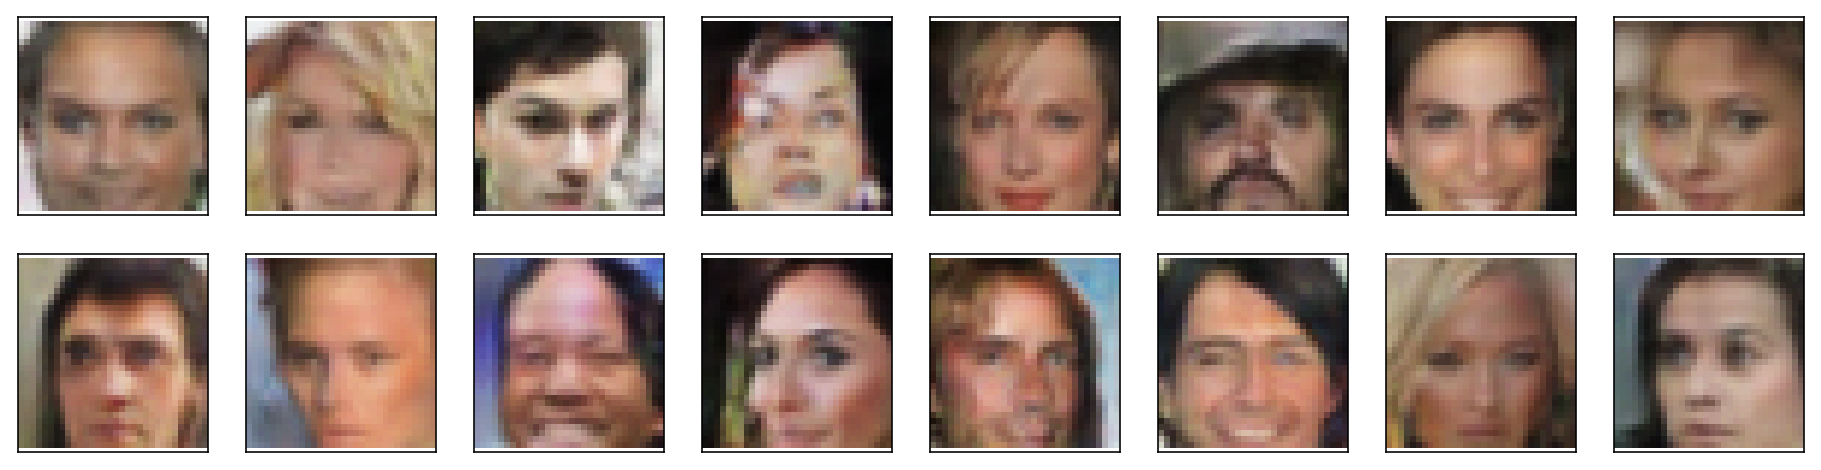

In [35]:
# Visualize the samples for epoch 40:
view_samples(-1, samples)

Here, we can the effects of the training on the fixed data which have been used for sampling. As it can be seen, we arrived to consistent results, generating pretty realistic faces, with some interesting changes - gender, age, hair color, facial expression, skin color... - over the epochs (e.g. on top raw, the second picture from the right, or on bottom raw, the tird picture from the left)... and some other pictures seem to have been taken out from a scary horror movie (e.g. on bottom raw, the first picture from the left, at epochs 20, 25 or 30)!

## Appendix: What do we notice about our generated samples and how might we improve this model?

We are going to answer this question considering three points.

First, it is important to note that the dataset we have used is biased: Indeed, it is made of "celebrity" faces that are mostly white. So, if we want our model to reflect more diversity (so, more diversity respectively to color skin, but equally more diversity respectively to gender, age, facial expression...), we need to augment the dataset and impove it to have it taking into account these aspects.

Respectively to the dataset, it can equally be said that larger images can be an option to consider if possible.

Secondly, we could consider the opportunity to improve the architecture of our model. For CNNs, we know that deeper we go respectively to the number of layers, the best our model will be in capturing complex features (for exemple, here, some pictures represent "celebrities" with eye glasses, other with sun glasses, hats...).

To make our model put the focus exclusively into faces, we can equally consider the option to whiten the backround around the faces.

Finally, considering other technical aspects, we can consider the option to use different loss functions (e.g. Wasserstein GAN loss), deploy attention technique, tune the hyperparameters (learning rate, add dropout...), and, for sure, augment the number of epochs!